In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_excel("superstore_final_dataset.xlsx")

A/B testing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9800 non-null   int64  
 1   Order_ID       9800 non-null   object 
 2   Order_Date     9800 non-null   object 
 3   Ship_Date      9800 non-null   object 
 4   Ship_Mode      9800 non-null   object 
 5   Customer_ID    9800 non-null   object 
 6   Customer_Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal_Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product_ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub_Category   9800 non-null   object 
 16  Product_Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [4]:
print(df.head())

   Row_ID        Order_ID           Order_Date            Ship_Date  \
0       1  CA-2017-152156  2017-08-11 00:00:00  2017-11-11 00:00:00   
1       2  CA-2017-152156  2017-08-11 00:00:00  2017-11-11 00:00:00   
2       3  CA-2017-138688  2017-12-06 00:00:00           16/06/2017   
3       4  US-2016-108966  2016-11-10 00:00:00           18/10/2016   
4       5  US-2016-108966  2016-11-10 00:00:00           18/10/2016   

        Ship_Mode Customer_ID    Customer_Name    Segment        Country  \
0    Second Class    CG-12520      Claire Gute   Consumer  United States   
1    Second Class    CG-12520      Claire Gute   Consumer  United States   
2    Second Class    DV-13045  Darrin Van Huff  Corporate  United States   
3  Standard Class    SO-20335    Sean O Donnel   Consumer  United States   
4  Standard Class    SO-20335    Sean O Donnel   Consumer  United States   

              City       State  Postal_Code Region       Product_ID  \
0        Henderson    Kentucky      42420.0  

In [5]:
product_count = df['Category'].value_counts()
print(product_count)

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64


In [6]:
State_Count = df['State'].value_counts()
print(State_Count)

State
California              1946
New York                1097
Texas                    973
Pennsylvania             582
Washington               504
Illinois                 483
Ohio                     454
Florida                  373
Michigan                 253
North Carolina           247
Virginia                 224
Arizona                  223
Tennessee                183
Colorado                 179
Georgia                  177
Kentucky                 137
Indiana                  135
Massachusetts            135
Oregon                   122
New Jersey               122
Maryland                 105
Wisconsin                105
Delaware                  93
Minnesota                 89
Connecticut               82
Missouri                  66
Oklahoma                  66
Alabama                   61
Arkansas                  60
Rhode Island              55
Mississippi               53
Utah                      53
South Carolina            42
Louisiana                 41
Nevada  

In [7]:
segment_counts = df['Segment'].value_counts()
print(segment_counts)

Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64


In [8]:
print(df.groupby('Segment')['Sales'].agg(['count', 'mean']))

             count        mean
Segment                       
Consumer      5101  225.065777
Corporate     2953  233.150720
Home Office   1746  243.403309


In [9]:
group_consumer = df[df['Segment'] == 'Consumer']['Sales']
group_corporate = df[df['Segment'] == 'Corporate']['Sales']
group_home_office = df[df['Segment'] == 'Home Office']['Sales']

t_statistic_consumer_corporate, p_value_consumer_corporate = ttest_ind(group_consumer, group_corporate)
t_statistic_consumer_home_office, p_value_consumer_home_office = ttest_ind(group_consumer, group_home_office)
t_statistic_corporate_home_office, p_value_corporate_home_office = ttest_ind(group_corporate, group_home_office)

print('T-statistic (consumer vs. corporate):', t_statistic_consumer_corporate)
print('P-value (consumer vs. corporate):', p_value_consumer_corporate)
print('T-statistic (consumer vs. home office):', t_statistic_consumer_home_office)
print('P-value (consumer vs. home office):', p_value_consumer_home_office)

T-statistic (consumer vs. corporate): -0.5895690051273899
P-value (consumer vs. corporate): 0.5554961783346866
T-statistic (consumer vs. home office): -1.0369552034113858
P-value (consumer vs. home office): 0.29979336448304184



A/B Testing for Segment: Consumer

Greatest significance state for Segment: Consumer
Greatest significance state: New York with P-value: 0.021491670207239057


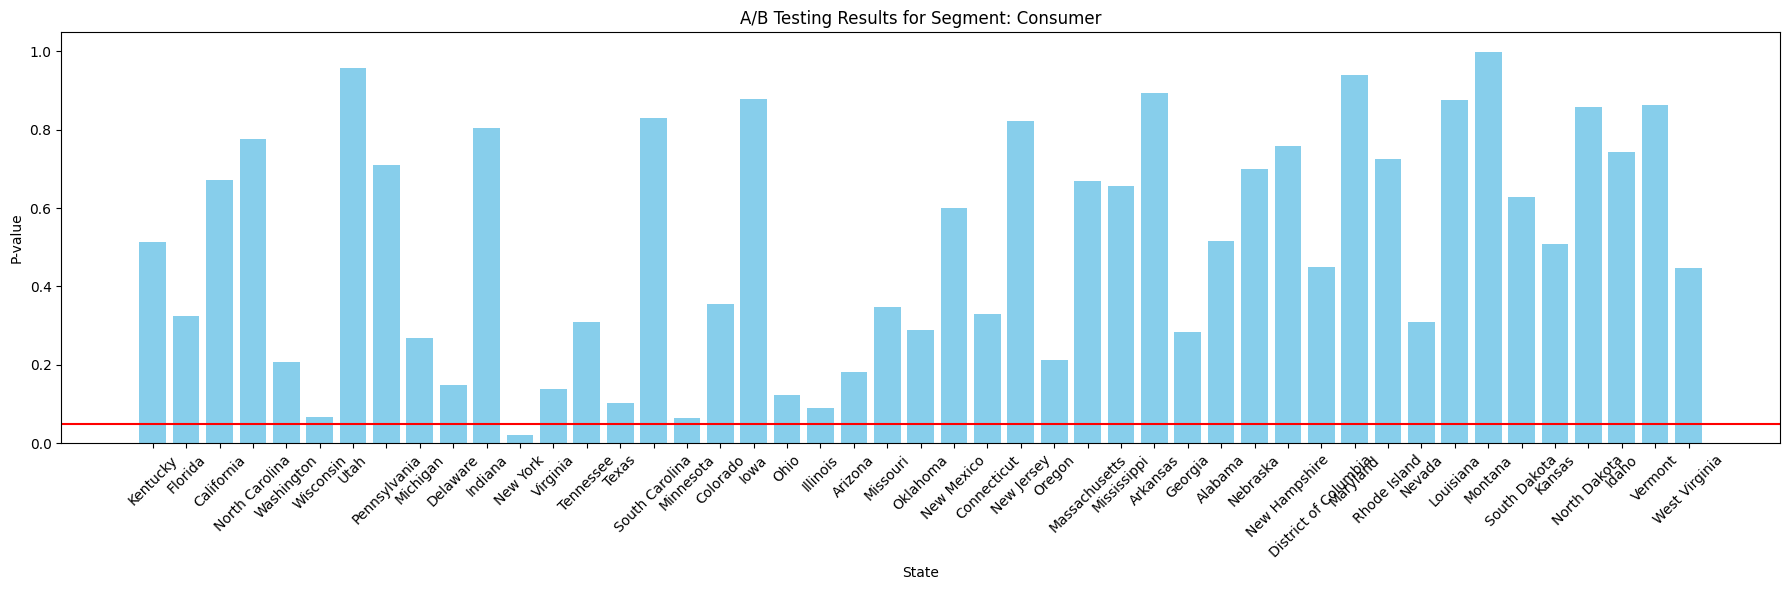


A/B Testing for Segment: Corporate

Greatest significance state for Segment: Corporate
Greatest significance state: Indiana with P-value: 1.1645167282882582e-07


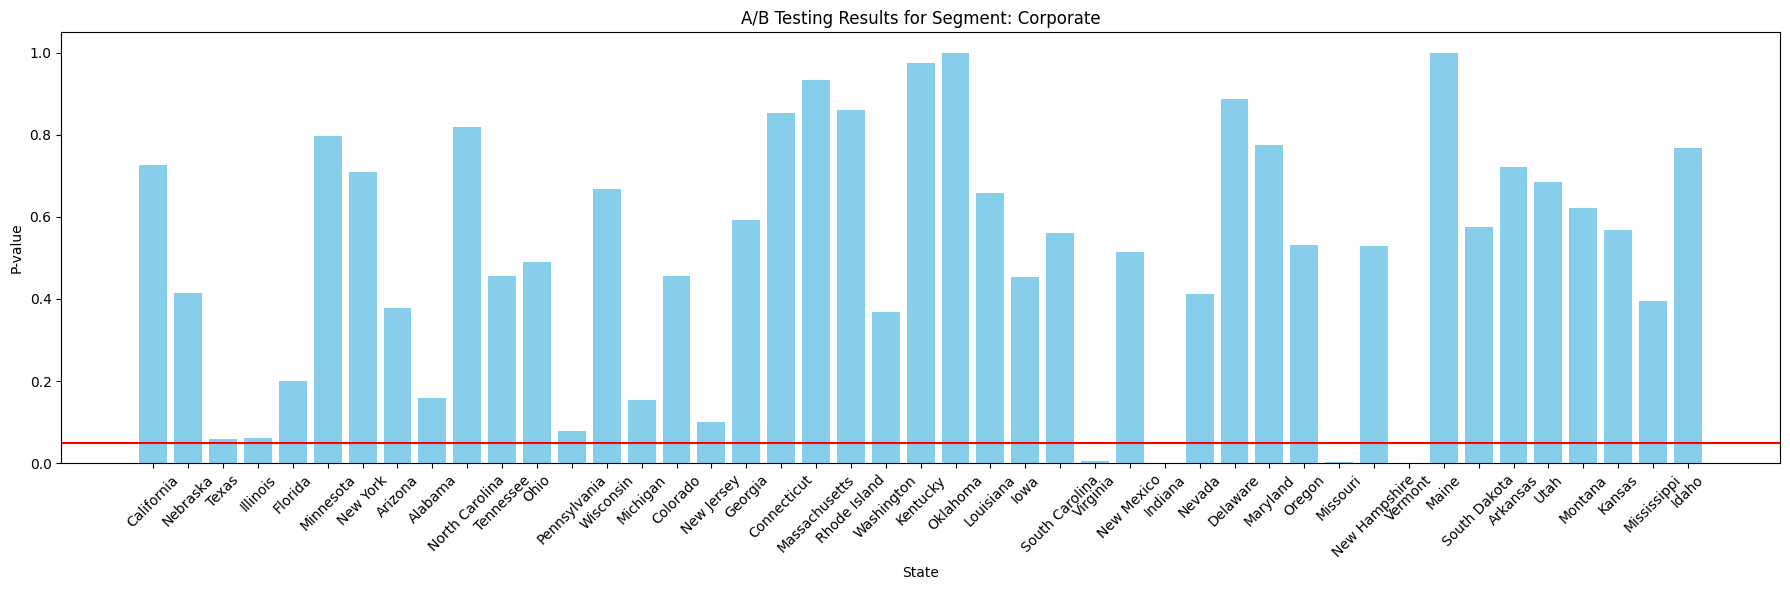


A/B Testing for Segment: Home Office

Greatest significance state for Segment: Home Office
Greatest significance state: Florida with P-value: 0.0022760400622442558


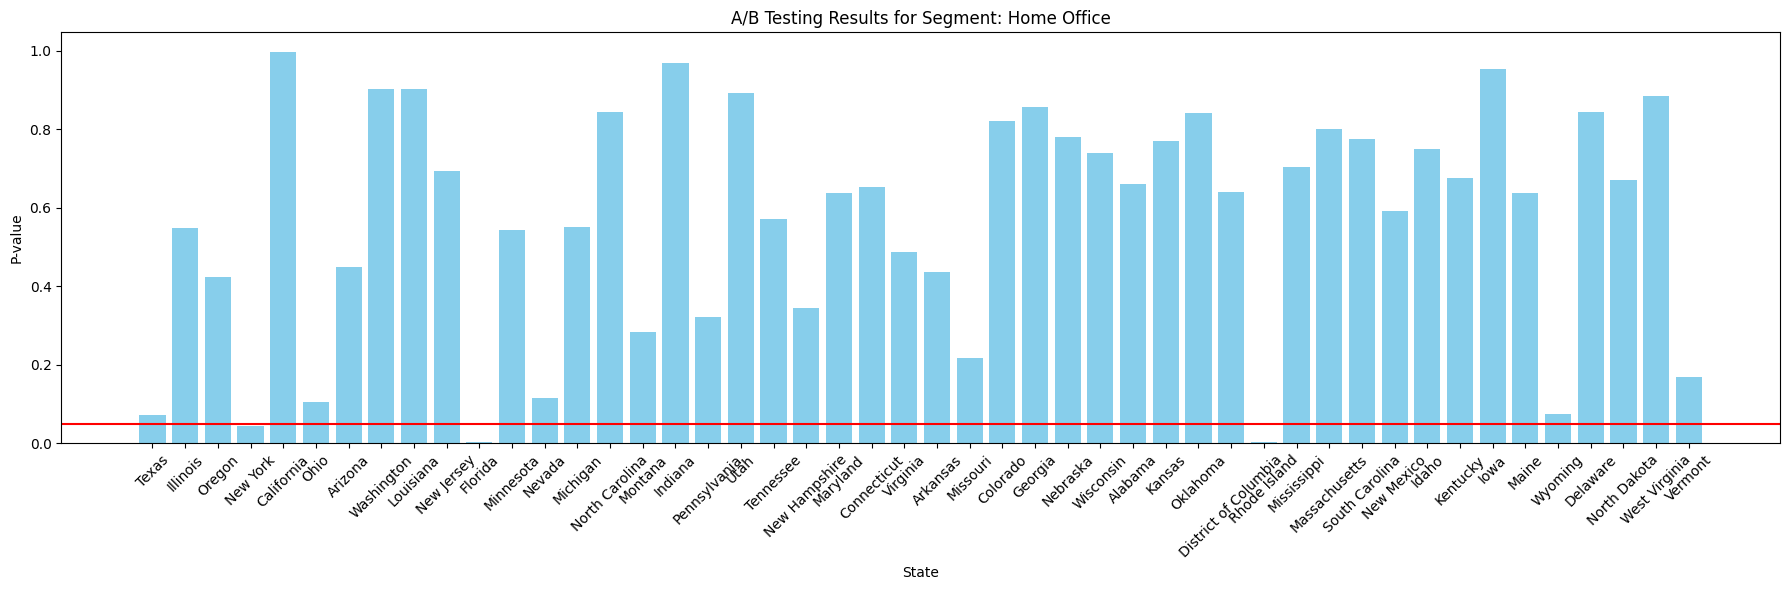

In [12]:
segments = df['Segment'].unique()

for segment in segments:
    print(f"\nA/B Testing for Segment: {segment}")
    segment_data = df[df['Segment'] == segment]
    states = segment_data['State'].unique()

    greatest_significance_state = None
    greatest_significance_p_value = 1

    p_values = []
    for state in states:
        group_A = segment_data[segment_data['State'] == state]['Sales']
        group_B = segment_data[segment_data['State'] != state]['Sales']

        t_statistic, p_value = ttest_ind(group_A, group_B)

        p_values.append(p_value)

        if p_value < greatest_significance_p_value:
            greatest_significance_p_value = p_value
            greatest_significance_state = state

    if greatest_significance_state:
        print(f"\nGreatest significance state for Segment: {segment}")
        print(f"Greatest significance state: {greatest_significance_state} with P-value: {greatest_significance_p_value}")
    else:
        print(f"No statistically significant difference found for Segment: {segment}")


    plt.figure(figsize=(18, 6))
    plt.bar(states, p_values, color='skyblue')
    plt.xlabel('State')
    plt.ylabel('P-value')
    plt.title(f'A/B Testing Results for Segment: {segment}')
    plt.axhline(y=0.05, color='r', linestyle='-')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [13]:
segments = df['Segment'].unique()

for segment in segments:
    print(f"\nA/B Testing for Segment: {segment}")
    segment_data = df[df['Segment'] == segment]
    states = segment_data['State'].unique()

    greatest_significance_state_greater = None
    greatest_significance_p_value_greater = 1
    least_significant_state_lesser = None
    least_significant_p_value_lesser = 1

    p_values_greater = []
    p_values_lesser = []

    for state in states:
        group_A = segment_data[segment_data['State'] == state]['Sales']
        group_B = segment_data[segment_data['State'] != state]['Sales']

        # Greater
        t_statistic_greater, p_value_greater = ttest_ind(group_A, group_B, alternative='greater')

        # Lesser
        t_statistic_lesser, p_value_lesser = ttest_ind(group_A, group_B, alternative='less')

        p_values_greater.append(p_value_greater)
        p_values_lesser.append(p_value_lesser)

        if p_value_greater < greatest_significance_p_value_greater:
            greatest_significance_p_value_greater = p_value_greater
            greatest_significance_state_greater = state

        if p_value_lesser < least_significant_p_value_lesser:
            least_significant_p_value_lesser = p_value_lesser
            least_significant_state_lesser = state

    if greatest_significance_state_greater:
        print(f"\nGreatest significance state (greater) for Segment: {segment}")
        print(f"Greatest significance state: {highest_significance_state_greater} with P-value: {highest_significance_p_value_greater}")
    else:
        print(f"No statistically significant difference found (greater) for Segment: {segment}")

    if least_significant_state_lesser:
        print(f"\nLeast significant state (lesser) for Segment: {segment}")
        print(f"Least significant state: {least_significant_state_lesser} with P-value: {least_significant_p_value_lesser}")
    else:
        print(f"No statistically significant difference found (lesser) for Segment: {segment}")


A/B Testing for Segment: Consumer

Greatest significance state (greater) for Segment: Consumer
Greatest significance state: Florida with P-value: 0.0011380200311221279

Least significant state (lesser) for Segment: Consumer
Least significant state: Illinois with P-value: 0.04543345911599625

A/B Testing for Segment: Corporate

Greatest significance state (greater) for Segment: Corporate
Greatest significance state: Florida with P-value: 0.0011380200311221279

Least significant state (lesser) for Segment: Corporate
Least significant state: Texas with P-value: 0.029193729766864955

A/B Testing for Segment: Home Office

Greatest significance state (greater) for Segment: Home Office
Greatest significance state: Florida with P-value: 0.0011380200311221279

Least significant state (lesser) for Segment: Home Office
Least significant state: Texas with P-value: 0.03598392894413429


Forecasting

In [17]:
df.groupby('Order_Date')

In [18]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
print(df.head())

   Row_ID        Order_ID Order_Date            Ship_Date       Ship_Mode  \
0       1  CA-2017-152156 2017-08-11  2017-11-11 00:00:00    Second Class   
1       2  CA-2017-152156 2017-08-11  2017-11-11 00:00:00    Second Class   
2       3  CA-2017-138688 2017-12-06           16/06/2017    Second Class   
3       4  US-2016-108966 2016-11-10           18/10/2016  Standard Class   
4       5  US-2016-108966 2016-11-10           18/10/2016  Standard Class   

  Customer_ID    Customer_Name    Segment        Country             City  \
0    CG-12520      Claire Gute   Consumer  United States        Henderson   
1    CG-12520      Claire Gute   Consumer  United States        Henderson   
2    DV-13045  Darrin Van Huff  Corporate  United States      Los Angeles   
3    SO-20335    Sean O Donnel   Consumer  United States  Fort Lauderdale   
4    SO-20335    Sean O Donnel   Consumer  United States  Fort Lauderdale   

        State  Postal_Code Region       Product_ID         Category  \
0  

In [19]:
daily_sales = df.groupby('Order_Date')['Sales'].sum()
print(daily_sales)

Order_Date
2015-01-02     468.9000
2015-01-03    2203.1510
2015-01-04     119.8880
2015-01-06    5188.5200
2015-01-07     601.0240
                ...    
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Name: Sales, Length: 1230, dtype: float64


In [20]:
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales.iloc[:train_size], daily_sales.iloc[train_size:]

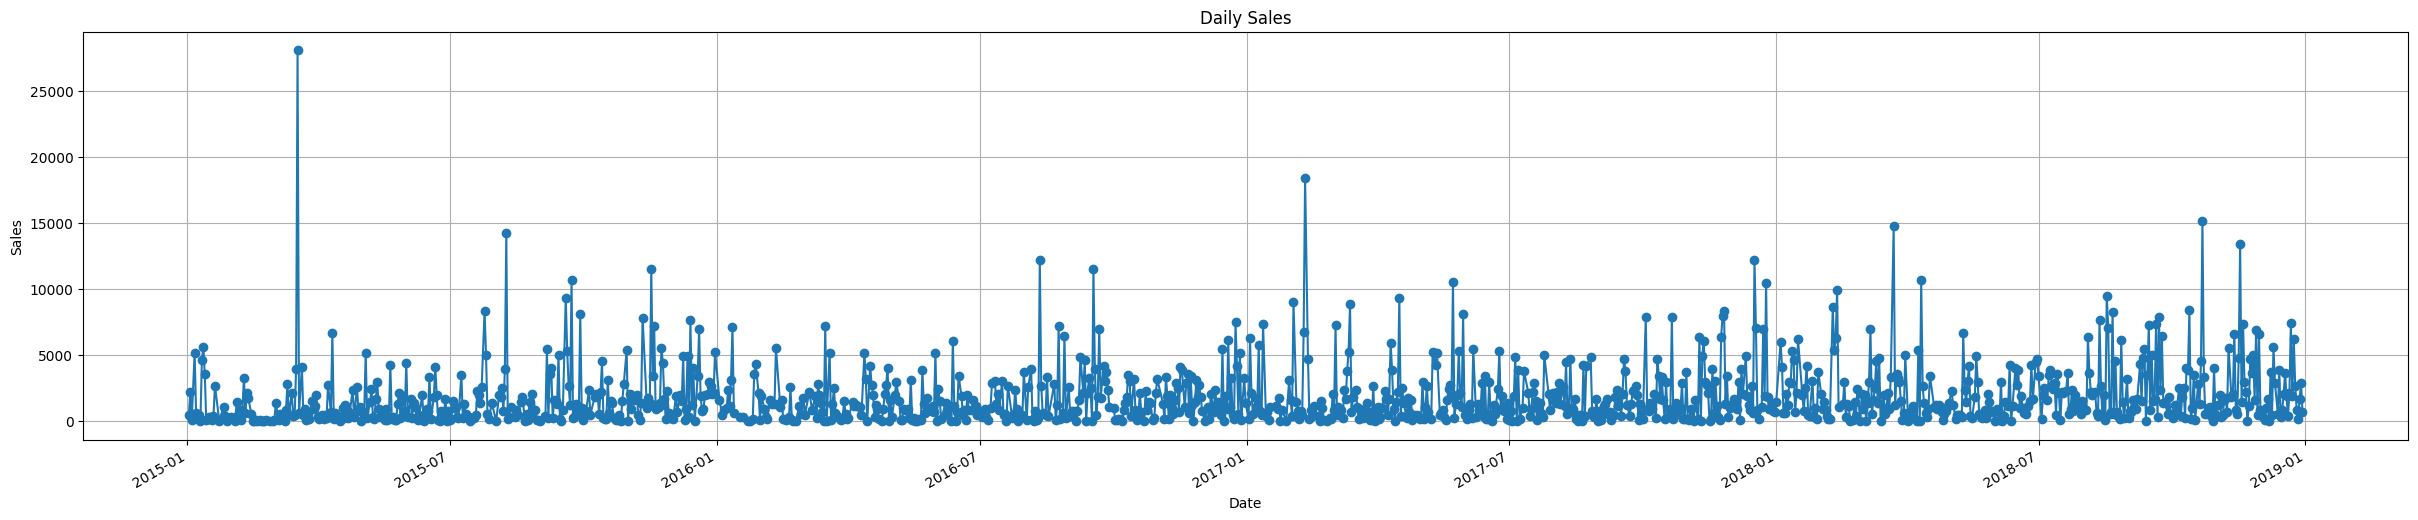

In [21]:
plt.figure(figsize=(30, 6))
daily_sales.plot(marker='o', linestyle='-')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


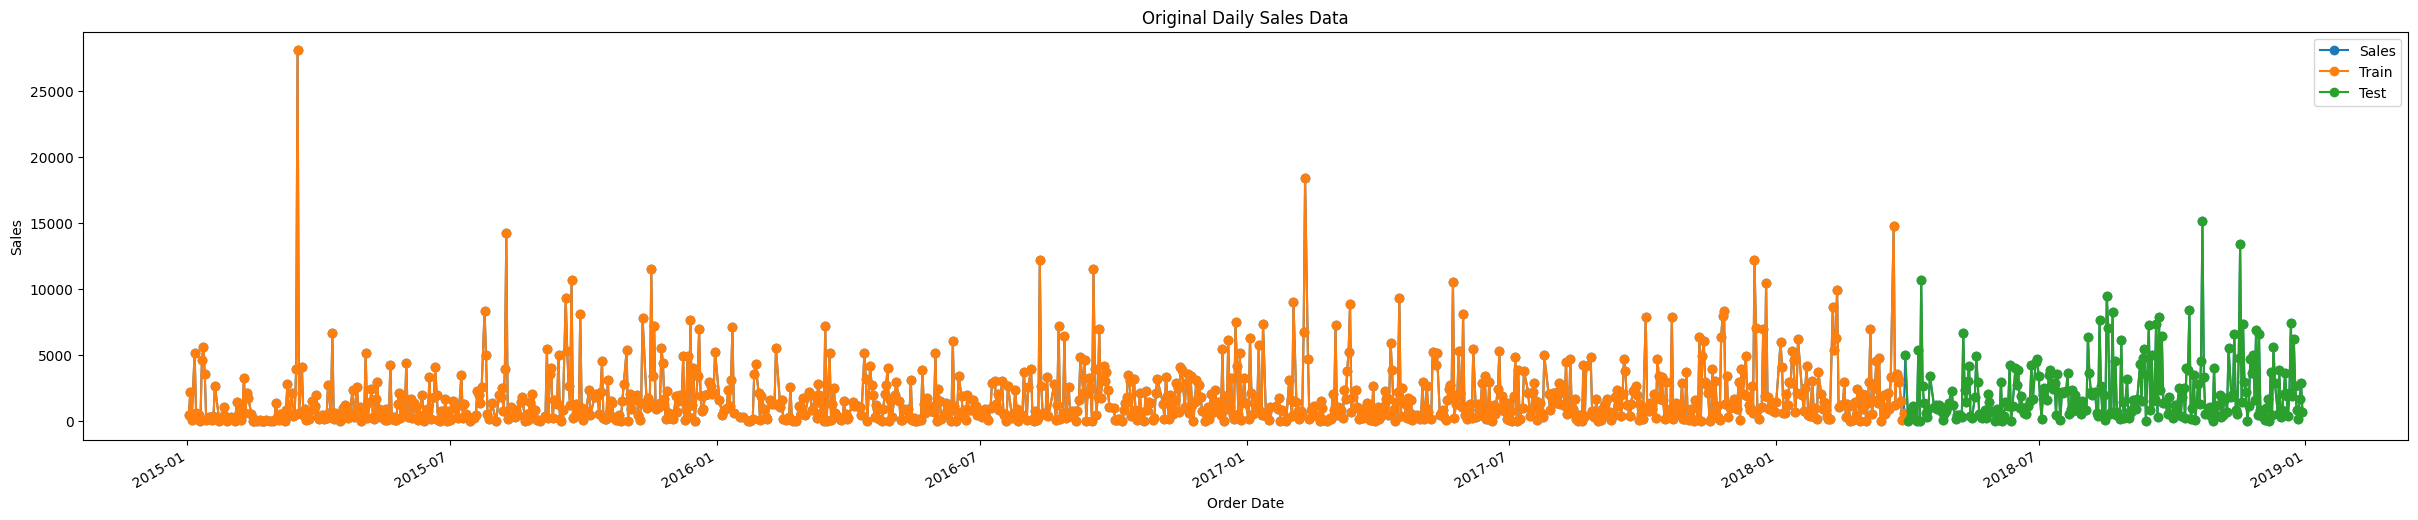

In [22]:
plt.figure(figsize=(30, 6))
daily_sales.plot(marker='o', linestyle='-')
plt.plot(train, label='Train', marker='o', linestyle='-')
plt.plot(test, label='Test', marker='o', linestyle='-')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Original Daily Sales Data')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

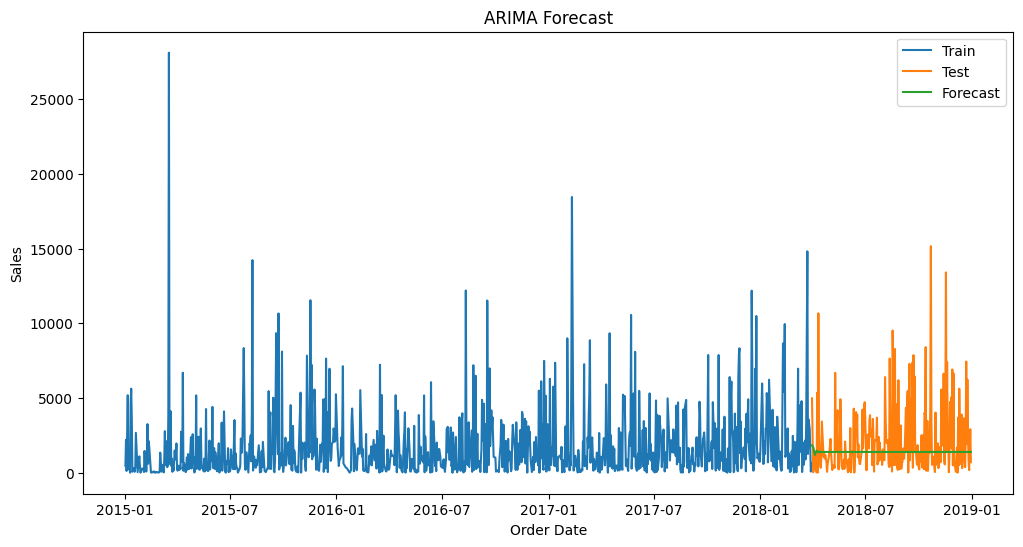

In [23]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()


forecast_periods = len(test)
forecast = model_fit.forecast(steps=forecast_periods)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


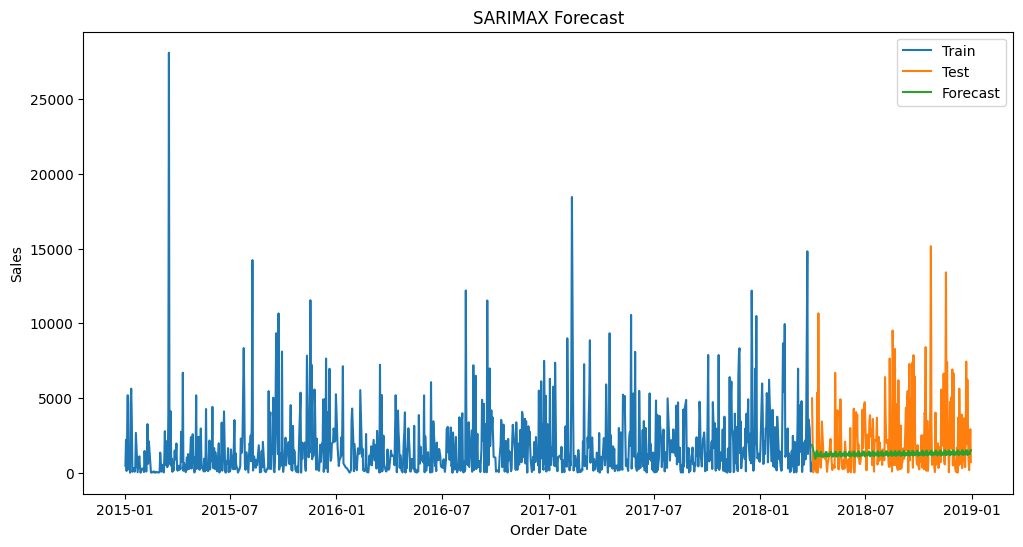

In [25]:

model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)


forecast_periods = len(test)
forecast = model_fit.forecast(steps=forecast_periods)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

In [ ]:
window_size = 12
moving_avg = daily_sales.rolling(window=window_size).mean()

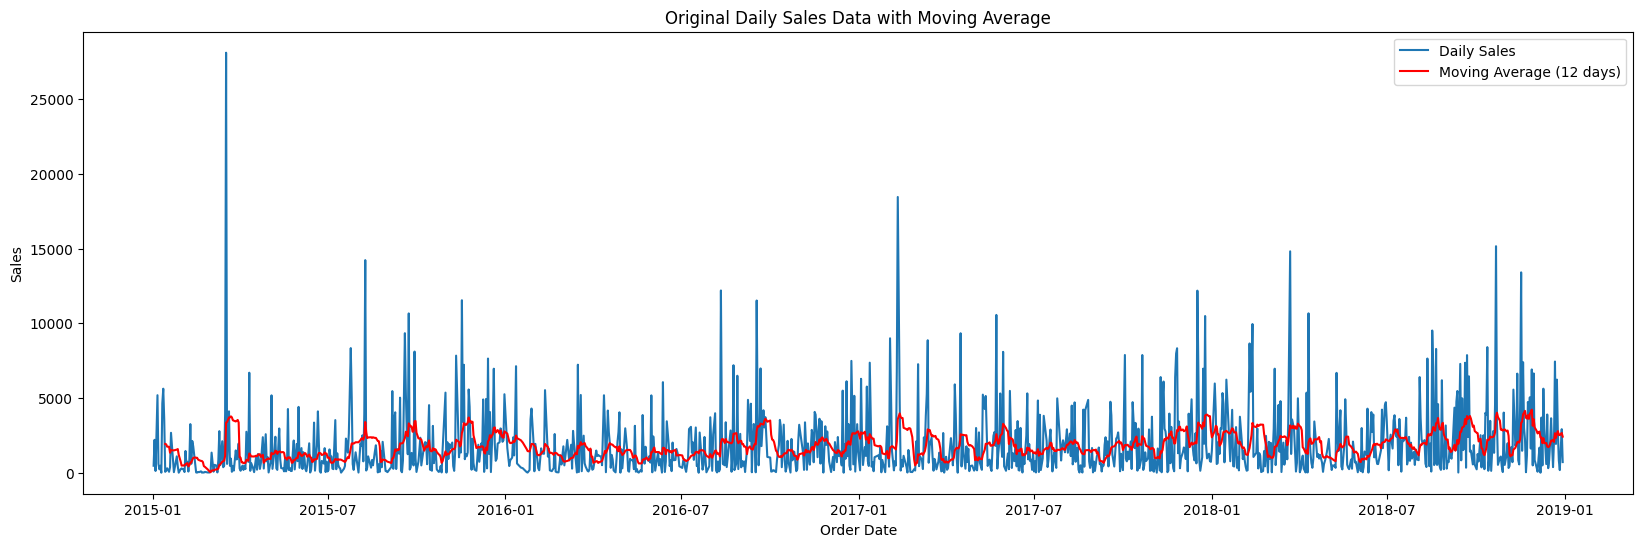

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Daily Sales')
plt.plot(daily_sales.index, moving_avg, color='red', label='Moving Average ({} days)'.format(window_size))
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Original Daily Sales Data with Moving Average')
plt.legend()
plt.show()

In [ ]:
df['Month'] = df['Order_Date'].dt.month

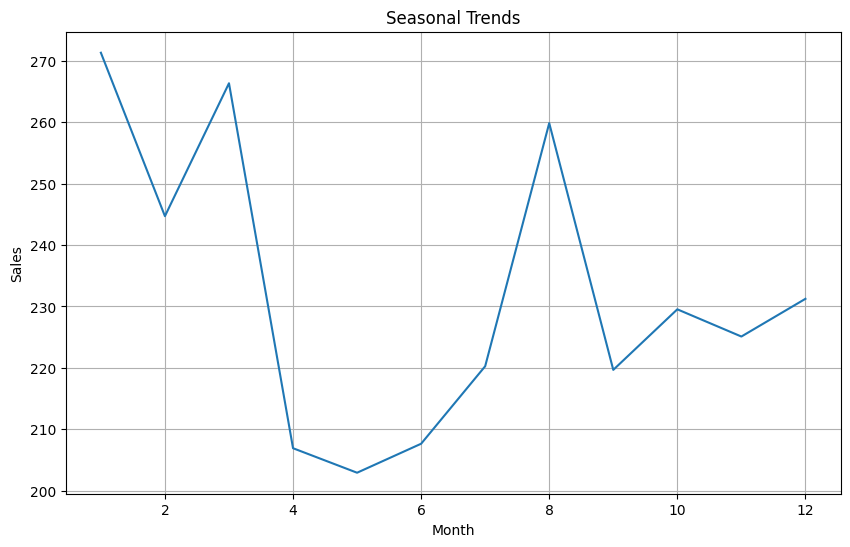

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Sales', data=df, errorbar=None)
plt.title('Seasonal Trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()